In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import numpy as np
import torch

In [62]:
from ACAgraphML.Dataset import ZINC_Dataset

NUM_NODE_FEATS = 28
NUM_EDGE_FEATS = 4

trainDataset = ZINC_Dataset.SMALL_TRAIN.load()
valDataset = ZINC_Dataset.SMALL_VAL.load()

In [63]:
len(trainDataset), len(valDataset), torch.min(trainDataset.data.y), torch.max(trainDataset.data.y)

(10000, 1000, tensor(-42.0366), tensor(3.8048))

Target statistics: mean=0.0153, std=2.0109
Range: [-42.0366, 3.8048]


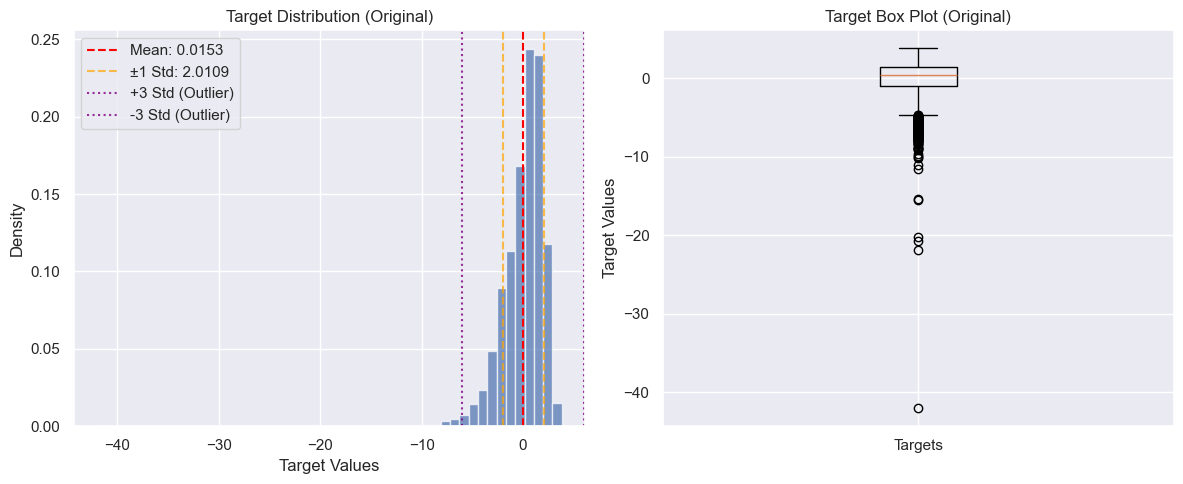

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)



Dataset sizes after filtering:
Training: 9893 (was 10000)
Validation: 988 (was 1000)

Min and max of targets in normalized datasets:
Train: -3.4398, 2.0837
Val: -3.0586, 2.1231

 Mean and std of targets in normalized datasets:
Train: -0.0000, 1.0000, original: 0.0153, 2.0109
Val: -0.0000, 1.0000, original: 0.0315, 1.9856

=== Testing normalization ===
Sample train target: 0.4115
Sample val target: 0.2903


c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


(9893, 988)

In [70]:
from ACAgraphML.Pipeline import TargetNormalizer

# Create the normalizer and fit it to the training data
target_normalizer = TargetNormalizer(verbose=True)
target_normalizer.fit(trainDataset)

# Create filtered and normalized datasets
normalized_train_dataset = target_normalizer.normalize(trainDataset)
normalized_val_dataset = target_normalizer.normalize(valDataset)

print(f"\nDataset sizes after filtering:")
print(f"Training: {len(normalized_train_dataset)} (was {len(trainDataset)})")
print(f"Validation: {len(normalized_val_dataset)} (was {len(valDataset)})")

#print min and max of the targets in the normalized datasets
print(f"\nMin and max of targets in normalized datasets:")
print(f"Train: {torch.min(normalized_train_dataset.y):.4f}, {torch.max(normalized_train_dataset.y):.4f}")
print(f"Val: {torch.min(normalized_val_dataset.y):.4f}, {torch.max(normalized_val_dataset.y):.4f}")

print(f"\n Mean and std of targets in normalized datasets:")
print(f"Train: {normalized_train_dataset.y.mean().item():.4f}, {normalized_train_dataset.y.std().item():.4f}, original: {trainDataset.data.y.mean().item():.4f}, {trainDataset.data.y.std().item():.4f}")
print(f"Val: {normalized_val_dataset.y.mean().item():.4f}, {normalized_val_dataset.y.std().item():.4f}, original: {valDataset.data.y.mean().item():.4f}, {valDataset.data.y.std().item():.4f}")

# Test that the normalization works
print(f"\n=== Testing normalization ===")
sample_train = normalized_train_dataset[0]
sample_val = normalized_val_dataset[0]
print(f"Sample train target: {sample_train.y.item():.4f}")
print(f"Sample val target: {sample_val.y.item():.4f}")

len(normalized_train_dataset), len(normalized_val_dataset)

In [72]:
from ACAgraphML.Transforms import SteadyStateTransform, OneHotEncodeFeat, OneHotEdgeFeats, AddMasterNode
from ACAgraphML.Pipeline import DataAugmenter
from torch_geometric.transforms import AddRandomWalkPE, AddLaplacianEigenvectorPE

addMasterNodeTransform = AddMasterNode()
oneHotEncodeFeatTransform = OneHotEncodeFeat(nClasses=NUM_NODE_FEATS)
oneHotEncodeFeatTransformEdge = OneHotEdgeFeats(nClasses=NUM_EDGE_FEATS)
steadyStateTransform = SteadyStateTransform(useEdgeWeights=False)
randomWalkPETransform = AddRandomWalkPE(walk_length=10, attr_name=None)
lapEigvecs = AddLaplacianEigenvectorPE(k=5, attr_name=None, normalization='sym', is_undirected=True)

transforms = [
    addMasterNodeTransform,
    oneHotEncodeFeatTransform,
    oneHotEncodeFeatTransformEdge,
    steadyStateTransform,
    randomWalkPETransform,
    lapEigvecs
]

trainAugmented = DataAugmenter(
    dataset=normalized_train_dataset,
    transforms=transforms
).augment()

valAugmented = DataAugmenter(
    dataset=normalized_val_dataset,
    transforms=transforms
).augment()

trainAugmented.x.shape, trainAugmented[0].x.shape, valAugmented.x.shape, valAugmented[0].x.shape 

Applying transforms:   0%|          | 0/9893 [00:00<?, ?it/s]

Applying transforms:   0%|          | 0/988 [00:00<?, ?it/s]

(torch.Size([239124, 44]),
 torch.Size([30, 44]),
 torch.Size([23824, 44]),
 torch.Size([36, 44]))

Number of components to keep: 23
Explained variance ratio: 0.9999186396598816
Using saved principal directions.


c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `

(torch.Size([239124, 23]),
 torch.Size([30, 23]),
 torch.Size([23824, 23]),
 torch.Size([36, 23]))

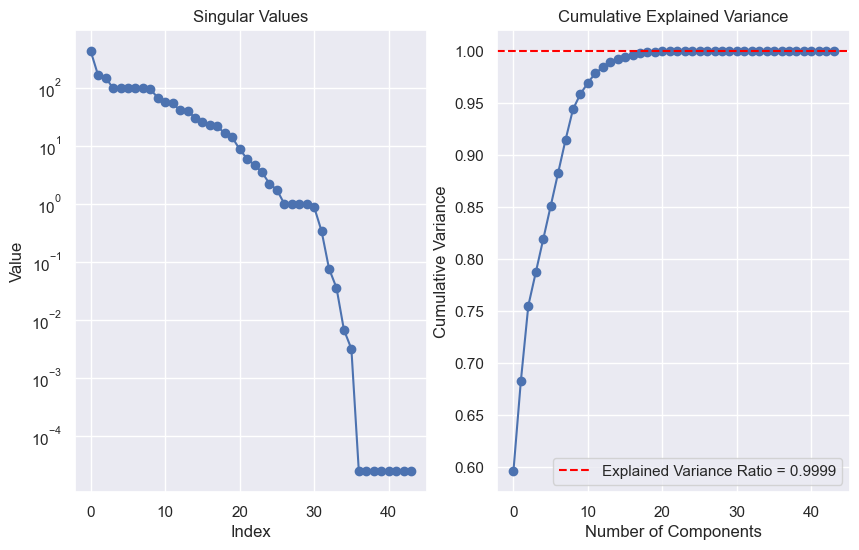

In [73]:
from ACAgraphML.Pipeline import DimentionalityReduction
dimentionalityReduction = DimentionalityReduction(explained_variance_ratio=0.9999, verbose=True)

trainDatasetReduced = dimentionalityReduction(trainAugmented)
valDatasetReduced = dimentionalityReduction(valAugmented, useState=True)

REDUCED_NUM_NODE_FEATS = trainDatasetReduced[0].x.shape[1]

trainDatasetReduced.x.shape, trainDatasetReduced[0].x.shape, valDatasetReduced.x.shape, valDatasetReduced[0].x.shape

In [93]:
from ACAgraphML.Pipeline.LightningModules import GDLPipelineLightningModule, create_lightning_baseline, create_lightning_standard, create_lightning_attention, create_lightning_advanced

GDLPipeline = create_lightning_advanced(REDUCED_NUM_NODE_FEATS, NUM_EDGE_FEATS)

print(GDLPipeline)

GDLPipelineLightningModule(
  (pipeline): GDLPipeline(
    (gnn): GNNModel(
      (input_proj): Linear(in_features=23, out_features=256, bias=True)
      (gnn_layers): ModuleList(
        (0-4): 5 x GINEConv(nn=Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        ))
      )
      (layer_norms): ModuleList(
        (0-4): 5 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (dropouts): ModuleList(
        (0-4): 5 x Dropout(p=0.15, inplace=False)
      )
    )
    (pooling): Pooling(
      (pooling_layer): AttentionalPooling(
        (attention_layer): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): Tanh()
          (2): Linear(in_features=256, out_features=1, bias=True)
        )
      )
    )
    (graph_dropout): Dropout(p=0.15, inplace=False)
    (graph_batch_norm): BatchNorm1d(256, eps=1e-05, mo

In [95]:
# Configure explicit TensorBoardLogger to ensure hparams.yaml is written
from lightning.pytorch import loggers as pl_loggers
import os

# Create the logger with explicit configuration
tb_logger = pl_loggers.TensorBoardLogger(
    save_dir="saved_models/Pipeline/Advanced/",
    name="lightning_logs",
    version=None,  # Let Lightning auto-increment the version
    default_hp_metric=True  # Enable hyperparameter logging
)

print("TensorBoardLogger configured:")
print(f"  Save directory: {tb_logger.save_dir}")
print(f"  Log directory: {tb_logger.log_dir}")
print(f"  Default HP metric: {tb_logger._default_hp_metric}")

import pytorch_lightning as pl
from torch_geometric.loader import DataLoader

pl.seed_everything(42)

# Create data loaders
train_loader = DataLoader(trainDatasetReduced, batch_size=32, shuffle=True)
val_loader = DataLoader(valDatasetReduced, batch_size=32, shuffle=False)


callbacks= [
    pl.callbacks.ModelCheckpoint(
        monitor='val_loss',
        filename='best_model',
        save_top_k=1,
        mode='min',
        save_weights_only=False,  # Ensure full model state is saved including hyperparameters
    ),
    pl.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min'
    )
]

# Use the already configured TensorBoardLogger from previous cell
# This ensures proper versioning and avoids conflicts

# Create trainer with the existing tb_logger
trainer = pl.Trainer(
    default_root_dir='./saved_models/Pipeline/Advanced',  # Specify custom log directory
    max_epochs=50,
    accelerator='auto',
    devices=1,
    log_every_n_steps=10,
    callbacks=callbacks,
    enable_progress_bar=True,
    logger=tb_logger,  # Use the tb_logger from previous cell
)

print(f"Trainer configured with logger:")
print(f"  Logger type: {type(trainer.logger)}")
print(f"  Log directory: {trainer.logger.log_dir}")
print(f"  Logger version: {trainer.logger.version}")

# Log hyperparameters before training to ensure hparams.yaml is written
print(f"Logging {len(GDLPipeline.hparams)} hyperparameters...")
tb_logger.log_hyperparams(GDLPipeline.hparams)

# Train the model
trainer.fit(GDLPipeline, train_loader, val_loader)

bestModel = GDLPipelineLightningModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type        | Params | Mode 
-------------------------------------------------
0 | pipeline | GDLPipeline | 1.7 M  | train
1 | loss_fn  | L1Loss      | 0      | train
-------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.880     Total estimated model params size (MB)
108       Modules in train mode
0         Modules in eval mode


TensorBoardLogger configured:
  Save directory: saved_models/Pipeline/Advanced/
  Log directory: saved_models/Pipeline/Advanced/lightning_logs\version_0
  Default HP metric: True
Trainer configured with logger:
  Logger type: <class 'lightning.pytorch.loggers.tensorboard.TensorBoardLogger'>
  Log directory: saved_models/Pipeline/Advanced/lightning_logs\version_0
  Logger version: 0
Logging 26 hyperparameters...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


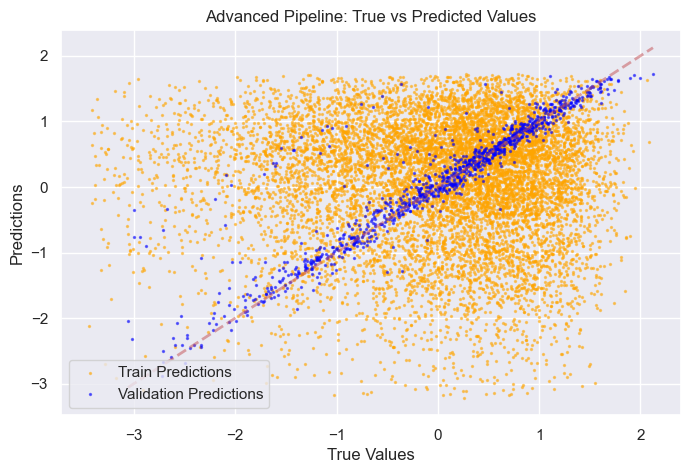

In [96]:
from ACAgraphML.utils import plotTrueVsPred

bestModel = GDLPipelineLightningModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

train_predictions = [
    bestModel.predict(
        x = batch.x,
        edge_index = batch.edge_index,
        edge_attr = batch.edge_attr,
        batch = batch.batch
    )
    for batch in train_loader
    ]
train_predictions = torch.cat(train_predictions, dim=0)

val_predictions = [
    bestModel.predict(
        x = batch.x,
        edge_index = batch.edge_index,
        edge_attr = batch.edge_attr,
        batch = batch.batch
    )
    for batch in val_loader
    ]
val_predictions = torch.cat(val_predictions, dim=0)

# Plot true vs predicted values
plotTrueVsPred(
    y = trainDatasetReduced.data.y,
    y_pred = train_predictions,
    y_val= valDatasetReduced.data.y,
    y_val_pred = val_predictions,
    title = "Advanced Pipeline: True vs Predicted Values",
    filename= "saved_models/Pipeline/Advanced/true_vs_pred.png",
    hardLimit=False
)

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


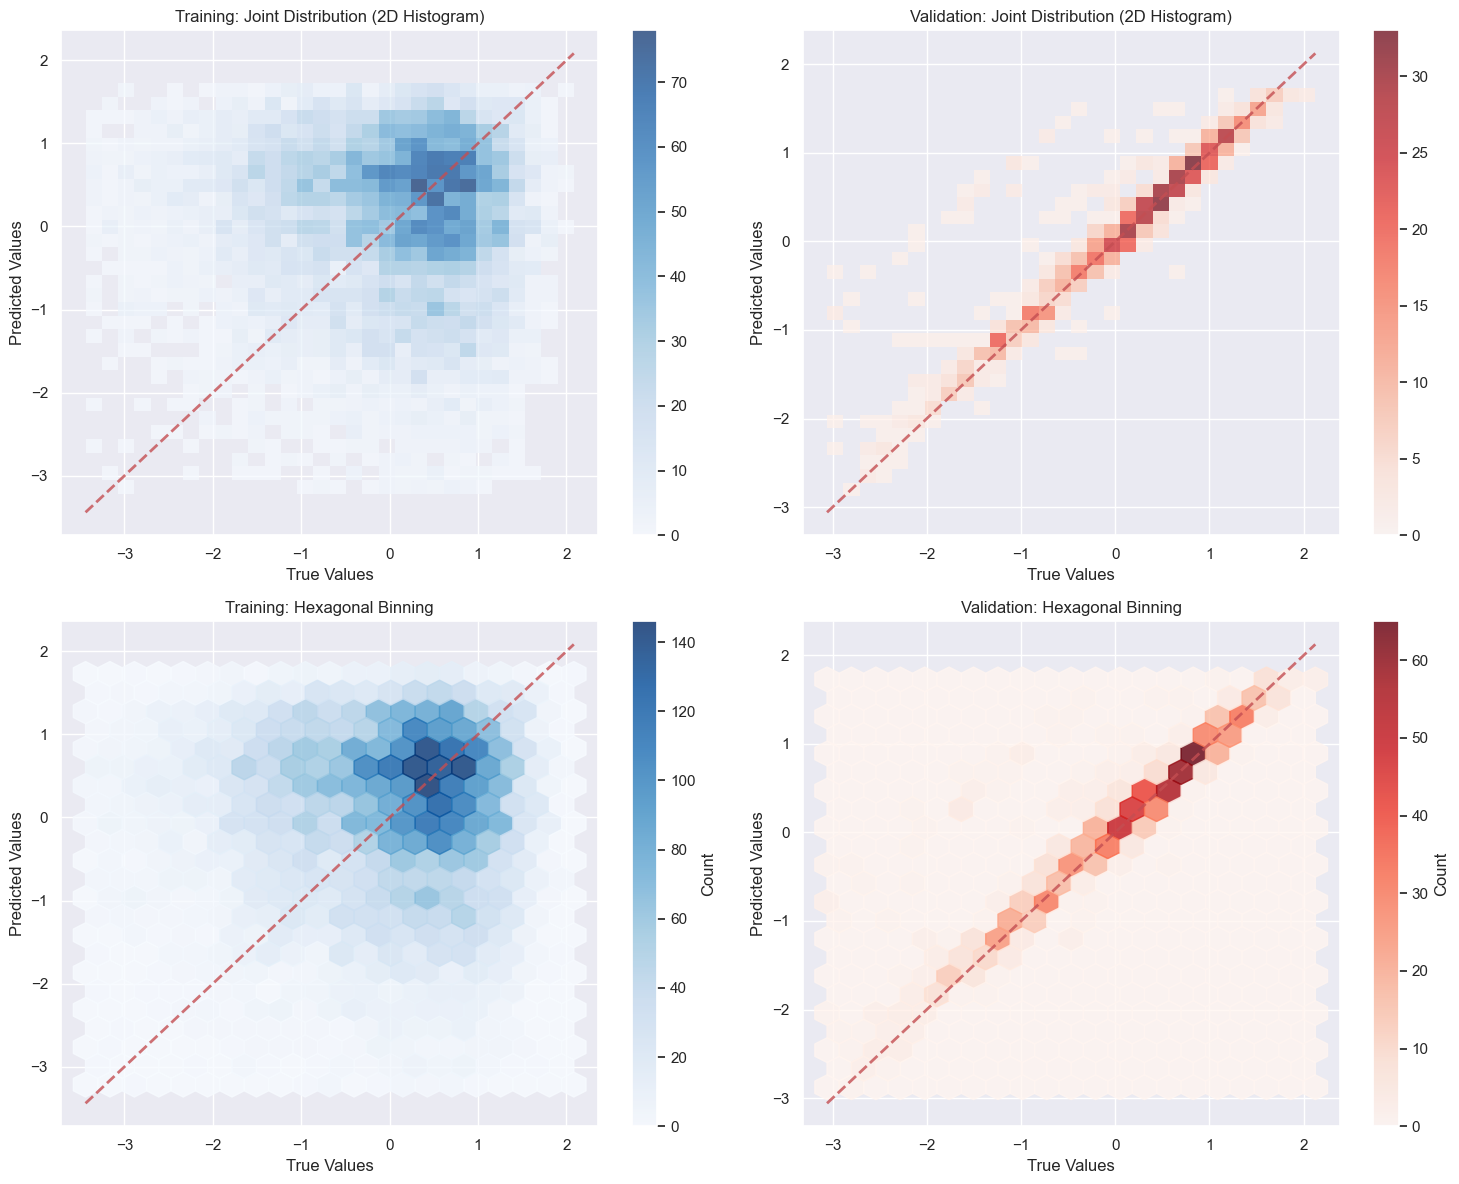

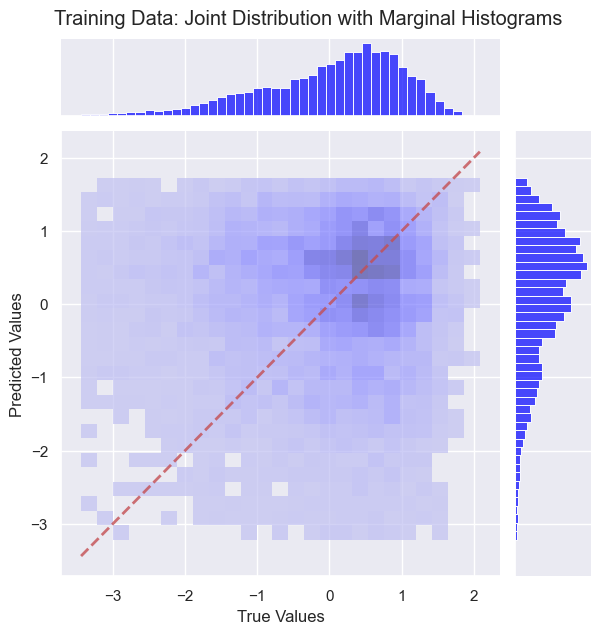

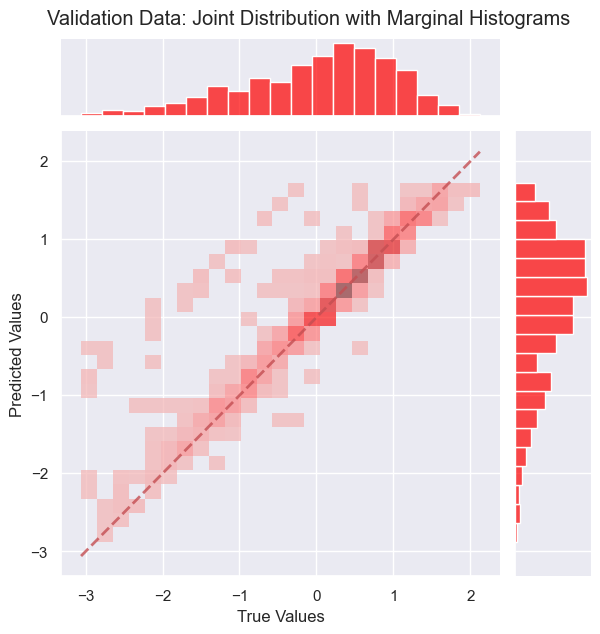

In [97]:
# Create joint distribution plots with histograms and density
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Convert to numpy arrays for easier handling
train_true = trainDatasetReduced.data.y.cpu().numpy()
train_pred = train_predictions.cpu().numpy()
val_true = valDatasetReduced.data.y.cpu().numpy()
val_pred = val_predictions.cpu().numpy()

# Plot 1: Training data - Joint plot with marginal histograms
plt.subplot(2, 2, 1)
sns.histplot(x=train_true, y=train_pred, bins=30, alpha=0.7, cmap='Blues', cbar=True)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Training: Joint Distribution (2D Histogram)')
# Add diagonal line
min_val = min(train_true.min(), train_pred.min())
max_val = max(train_true.max(), train_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)

# Plot 2: Validation data - Joint plot with marginal histograms
plt.subplot(2, 2, 2)
sns.histplot(x=val_true, y=val_pred, bins=30, alpha=0.7, cmap='Reds', cbar=True)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Validation: Joint Distribution (2D Histogram)')
# Add diagonal line
min_val = min(val_true.min(), val_pred.min())
max_val = max(val_true.max(), val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)

# Plot 3: Hexbin plot for training data
plt.subplot(2, 2, 3)
plt.hexbin(train_true, train_pred, gridsize=20, cmap='Blues', alpha=0.8)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Training: Hexagonal Binning')
plt.colorbar(label='Count')
# Add diagonal line
min_val = min(train_true.min(), train_pred.min())
max_val = max(train_true.max(), train_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)

# Plot 4: Hexbin plot for validation data
plt.subplot(2, 2, 4)
plt.hexbin(val_true, val_pred, gridsize=20, cmap='Reds', alpha=0.8)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Validation: Hexagonal Binning')
plt.colorbar(label='Count')
# Add diagonal line
min_val = min(val_true.min(), val_pred.min())
max_val = max(val_true.max(), val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)

plt.tight_layout()
plt.savefig('saved_models/Pipeline/Attention/joint_distribution_hist.png', dpi=300, bbox_inches='tight')
plt.show()

# Create separate figures with seaborn's jointplot for better marginal distributions
g1 = sns.jointplot(x=train_true, y=train_pred, kind='hist', bins=25, 
                   color='blue', alpha=0.7, marginal_kws={'alpha': 0.7})
g1.ax_joint.plot([train_true.min(), train_true.max()], 
                 [train_true.min(), train_true.max()], 'r--', alpha=0.8, linewidth=2)
g1.set_axis_labels('True Values', 'Predicted Values')
g1.fig.suptitle('Training Data: Joint Distribution with Marginal Histograms', y=1.02)

# Validation data jointplot
g2 = sns.jointplot(x=val_true, y=val_pred, kind='hist', bins=25, 
                   color='red', alpha=0.7, marginal_kws={'alpha': 0.7})
g2.ax_joint.plot([val_true.min(), val_true.max()], 
                 [val_true.min(), val_true.max()], 'r--', alpha=0.8, linewidth=2)
g2.set_axis_labels('True Values', 'Predicted Values')
g2.fig.suptitle('Validation Data: Joint Distribution with Marginal Histograms', y=1.02)

plt.savefig('saved_models/Pipeline/Attention/joint_marginal_hist.png', dpi=300, bbox_inches='tight')
plt.show()

In [98]:
import tqdm.notebook as tqdm


train_embeddings = []
train_targets = []

bestModel.eval()
with torch.no_grad():
    for batch in tqdm.tqdm(train_loader, desc="Extracting train embeddings"):
        # Get embeddings from the model (before final prediction layer)
        embeddings = bestModel.get_embeddings(
            x=batch.x,
            edge_index=batch.edge_index,
            edge_attr=batch.edge_attr,
            batch=batch.batch
        )
        train_embeddings.append(embeddings)
        train_targets.append(batch.y)

train_embeddings = torch.cat(train_embeddings, dim=0)
train_targets = torch.cat(train_targets, dim=0)

val_embeddings = []
val_targets = []

with torch.no_grad():
    for batch in tqdm.tqdm(val_loader, desc="Extracting val embeddings"):
        embeddings = bestModel.get_embeddings(
            x=batch.x,
            edge_index=batch.edge_index,
            edge_attr=batch.edge_attr,
            batch=batch.batch
        )
        val_embeddings.append(embeddings)
        val_targets.append(batch.y)

val_embeddings = torch.cat(val_embeddings, dim=0)
val_targets = torch.cat(val_targets, dim=0)

print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Val embeddings shape: {val_embeddings.shape}")
print(f"Train targets shape: {train_targets.shape}")
print(f"Val targets shape: {val_targets.shape}")

Extracting train embeddings:   0%|          | 0/310 [00:00<?, ?it/s]

Extracting val embeddings:   0%|          | 0/31 [00:00<?, ?it/s]

Train embeddings shape: torch.Size([9893, 256])
Val embeddings shape: torch.Size([988, 256])
Train targets shape: torch.Size([9893])
Val targets shape: torch.Size([988])


Combined embeddings shape: torch.Size([10881, 256])
Combined targets shape: torch.Size([10881])
Combined predictions shape: (10881,)
Applying t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10881 samples in 0.005s...
[t-SNE] Computed neighbors for 10881 samples in 1.168s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10881
[t-SNE] Computed conditional probabilities for sample 2000 / 10881
[t-SNE] Computed conditional probabilities for sample 3000 / 10881
[t-SNE] Computed conditional probabilities for sample 4000 / 10881
[t-SNE] Computed conditional probabilities for sample 5000 / 10881
[t-SNE] Computed conditional probabilities for sample 6000 / 10881
[t-SNE] Computed conditional probabilities for sample 7000 / 10881
[t-SNE] Computed conditional probabilities for sample 8000 / 10881
[t-SNE] Computed conditional probabilities for sample 9000 / 10881
[t-SNE] Computed conditional probabilities for sample 10000 / 10881
[t-SNE] Computed conditional probab

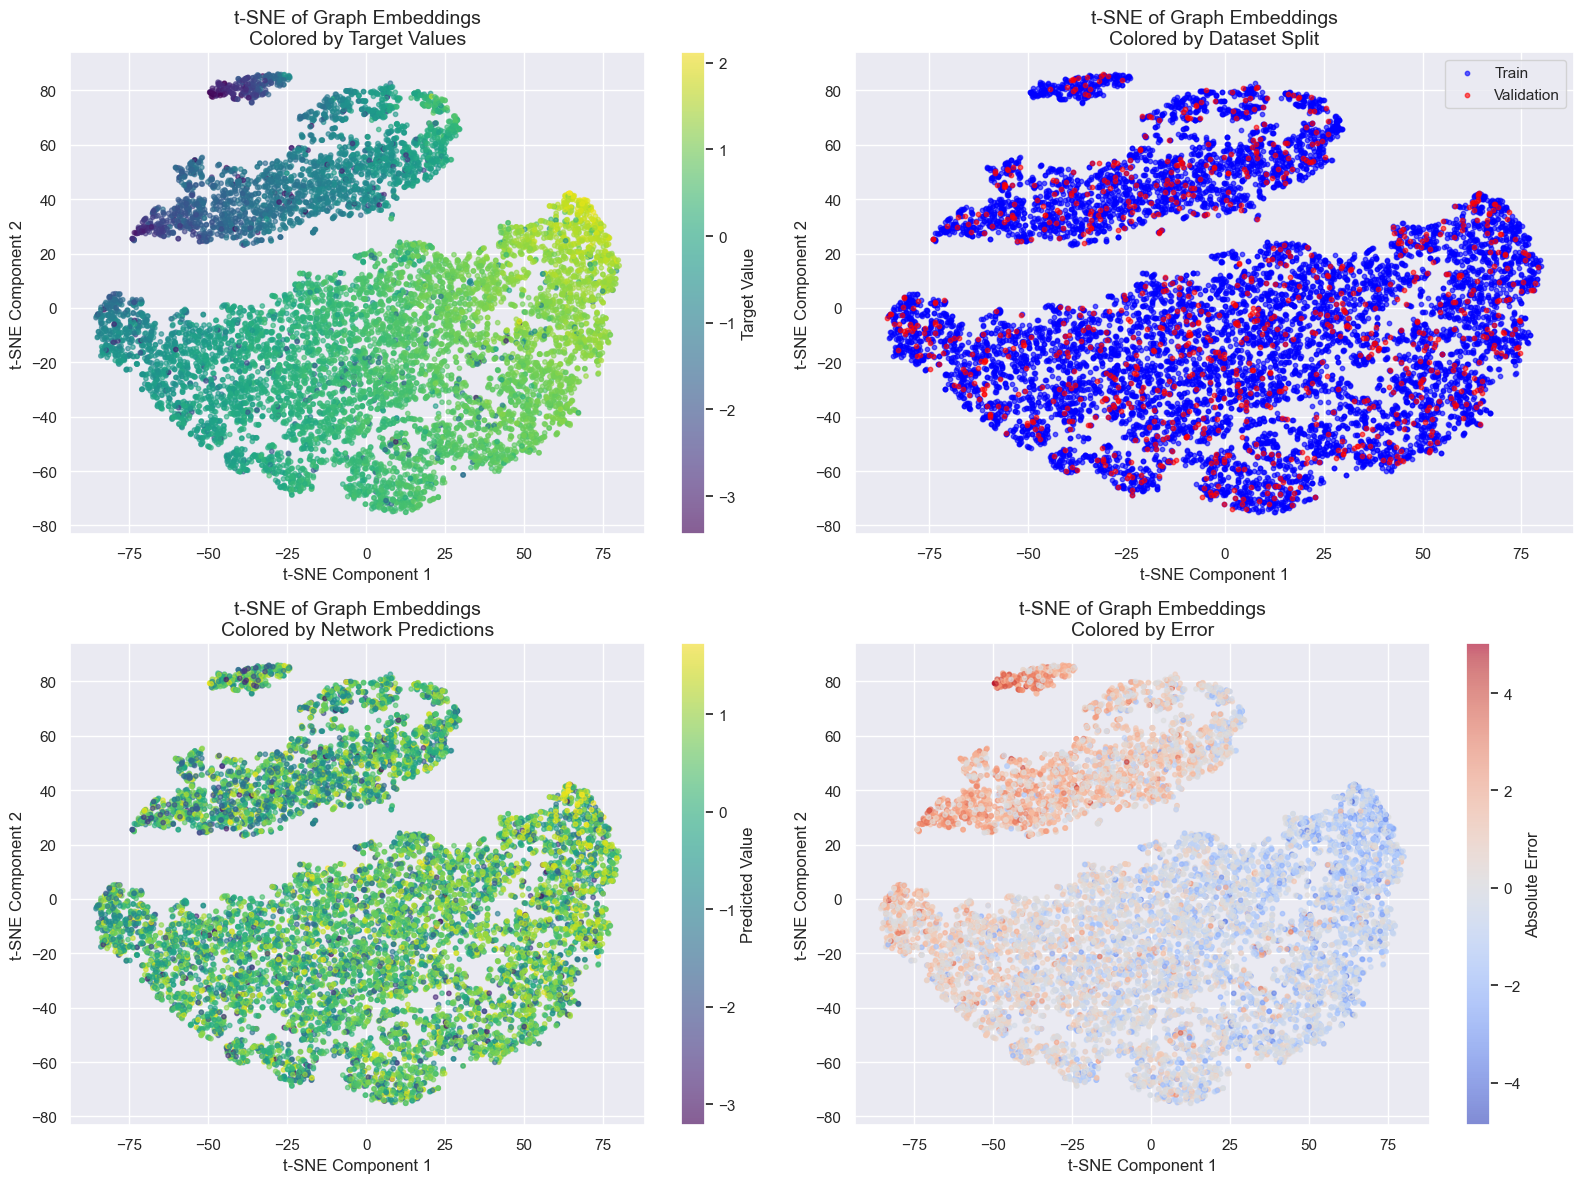


Target value statistics:
Min: -3.4398
Max: 2.1231
Mean: -0.0000
Std: 0.9999

Prediction value statistics:
Min: -3.2145
Max: 1.7274
Mean: 0.0868
Std: 0.9468

Absolute error statistics:
Min: -4.8730
Max: 5.0245
Mean: 0.0868
Std: 1.3153


In [99]:
# Install required packages for t-SNE visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Combine train and validation embeddings and targets
all_embeddings = torch.cat([train_embeddings, val_embeddings], dim=0)
all_targets = torch.cat([train_targets, val_targets], dim=0)
dataset_labels = ['Train'] * len(train_embeddings) + ['Val'] * len(val_embeddings)

# Combine XGBoost predictions
all_predictions = np.concatenate([train_predictions.cpu().numpy(), val_predictions])

print(f"Combined embeddings shape: {all_embeddings.shape}")
print(f"Combined targets shape: {all_targets.shape}")
print(f"Combined predictions shape: {all_predictions.shape}")

# Convert to numpy for t-SNE
embeddings_np = all_embeddings.cpu().numpy()
targets_np = all_targets.cpu().numpy()

# Calculate absolute error
absolute_errors = all_predictions - targets_np

# Apply t-SNE
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, verbose=1, n_jobs=-1)
embeddings_2d = tsne.fit_transform(embeddings_np)

print(f"t-SNE completed. Shape: {embeddings_2d.shape}")

# Create the plot with four subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Colored by target values
scatter1 = ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=targets_np, cmap='viridis', alpha=0.6, s=10)
ax1.set_title('t-SNE of Graph Embeddings\nColored by Target Values', fontsize=14)
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Target Value')

# Plot 2: Colored by dataset (train/val)
train_mask = np.array(dataset_labels) == 'Train'
val_mask = np.array(dataset_labels) == 'Val'

ax2.scatter(embeddings_2d[train_mask, 0], embeddings_2d[train_mask, 1], 
           c='blue', alpha=0.6, s=10, label='Train')
ax2.scatter(embeddings_2d[val_mask, 0], embeddings_2d[val_mask, 1], 
           c='red', alpha=0.6, s=10, label='Validation')
ax2.set_title('t-SNE of Graph Embeddings\nColored by Dataset Split', fontsize=14)
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.legend()

# Plot 3: Colored by Network predictions
scatter3 = ax3.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=all_predictions, cmap='viridis', alpha=0.6, s=10)
ax3.set_title('t-SNE of Graph Embeddings\nColored by Network Predictions', fontsize=14)
ax3.set_xlabel('t-SNE Component 1')
ax3.set_ylabel('t-SNE Component 2')
cbar3 = plt.colorbar(scatter3, ax=ax3)
cbar3.set_label('Predicted Value')

# Plot 4: Colored by absolute error
scatter4 = ax4.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=absolute_errors, cmap='coolwarm', alpha=0.6, s=10)
ax4.set_title('t-SNE of Graph Embeddings\nColored by Error', fontsize=14)
ax4.set_xlabel('t-SNE Component 1')
ax4.set_ylabel('t-SNE Component 2')
cbar4 = plt.colorbar(scatter4, ax=ax4)
cbar4.set_label('Absolute Error')

plt.tight_layout()
plt.savefig('saved_models/Pipeline/Attention/tsne_embeddings.png', dpi=300, bbox_inches='tight')
plt.show()

# Print some statistics
print(f"\nTarget value statistics:")
print(f"Min: {targets_np.min():.4f}")
print(f"Max: {targets_np.max():.4f}")
print(f"Mean: {targets_np.mean():.4f}")
print(f"Std: {targets_np.std():.4f}")

print(f"\nPrediction value statistics:")
print(f"Min: {all_predictions.min():.4f}")
print(f"Max: {all_predictions.max():.4f}")
print(f"Mean: {all_predictions.mean():.4f}")
print(f"Std: {all_predictions.std():.4f}")

print(f"\nAbsolute error statistics:")
print(f"Min: {absolute_errors.min():.4f}")
print(f"Max: {absolute_errors.max():.4f}")
print(f"Mean: {absolute_errors.mean():.4f}")
print(f"Std: {absolute_errors.std():.4f}")


XGBoost Regression Validation Metrics:
Mean Squared Error (MSE): 0.1519
R-squared (R2): 0.8480
Mean Absolute Error (MAE): 0.2090


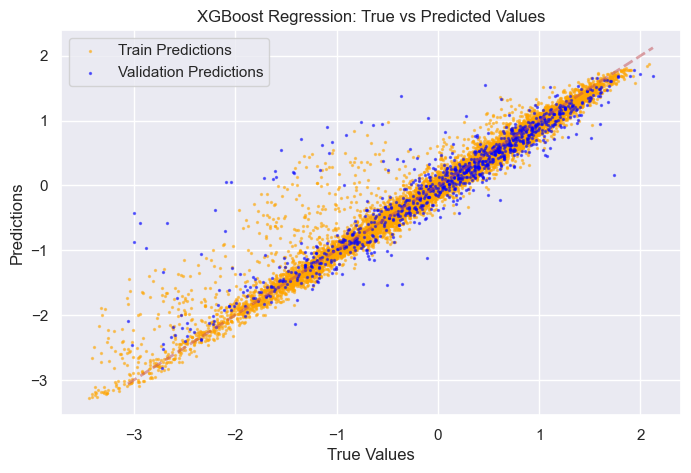

In [100]:
#Run xgboostRegression on the embeddings and print validation metrics
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Prepare training and validation data
X_train = train_embeddings.cpu().numpy()
y_train = train_targets.cpu().numpy()
X_val = val_embeddings.cpu().numpy()
y_val = val_targets.cpu().numpy()

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    n_jobs=-1,)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)
# Calculate metrics
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)

print(f"\nXGBoost Regression Validation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Plot true vs predicted values for XGBoost
plotTrueVsPred(
    y=y_train,
    y_pred=y_pred,
    y_val=y_val,
    y_val_pred=y_val_pred,
    title="XGBoost Regression: True vs Predicted Values",
    filename="saved_models/Pipeline/Attention/xgboost_true_vs_pred.png",
    hardLimit=False
)

[LibSVM]
SVR Regression Validation Metrics:
Mean Squared Error (MSE): 0.1503
R-squared (R2): 0.8495
Mean Absolute Error (MAE): 0.1801


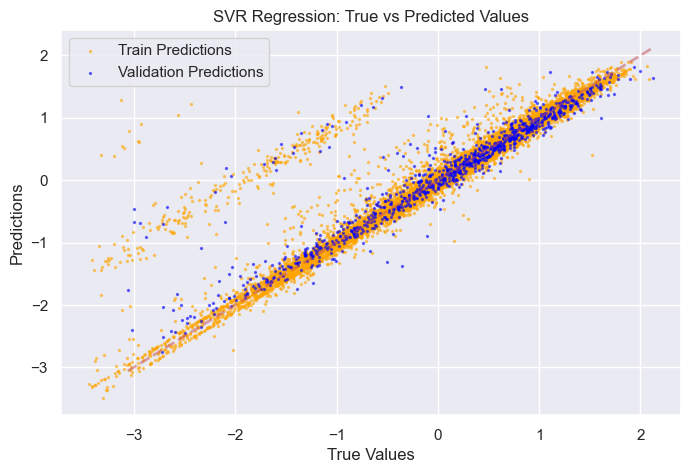

In [101]:
#SVR Regression on the embeddings and print validation metrics
from sklearn.svm import SVR

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1, verbose=True)
# Train the SVR model
svr_model.fit(X_train, y_train)
# Make predictions
y_svr_pred = svr_model.predict(X_train)
y_svr_pred_val = svr_model.predict(X_val)
# Calculate metrics for SVR
mse_svr = mean_squared_error(y_val, y_svr_pred_val)
r2_svr = r2_score(y_val, y_svr_pred_val)
mae_svr = mean_absolute_error(y_val, y_svr_pred_val)
print(f"\nSVR Regression Validation Metrics:")
print(f"Mean Squared Error (MSE): {mse_svr:.4f}")
print(f"R-squared (R2): {r2_svr:.4f}")
print(f"Mean Absolute Error (MAE): {mae_svr:.4f}")

# Plot true vs predicted values for SVR
plotTrueVsPred(
    y=y_train,
    y_pred=y_svr_pred,
    y_val=y_val,
    y_val_pred=y_svr_pred_val,
    title="SVR Regression: True vs Predicted Values",
    filename="saved_models/Pipeline/Attention/svr_true_vs_pred.png",
    hardLimit=False
)
